In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F


In [14]:
x_df = pd.read_csv('./new_features_3_sec.csv')
y_df = x_df['label']
x_df.drop(['filename','label'], axis=1, inplace=True)

means = x_df.iloc[:, ::2]
varis = x_df.iloc[:, ::2]

features = np.stack((means.values, varis.values), axis=-1)
X = np.transpose(features, (0,2,1))

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(y_df)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

batch_size = 64

train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=batch_size, shuffle=True)


In [ ]:
import torch.nn as nn

class FCN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FCN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cpu':
    raise RuntimeError("CUDA not available")

model = FCN(48, 10).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 250
for epoch in range(num_epochs):
    model.train()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            preds = torch.argmax(y_pred, dim=1)
            total += len(preds)
            correct += (preds == y_batch).sum().item()

    accuracy = (correct / total) * 100
    print("Epoch " + str(epoch) + " Accuracy: " + str(accuracy) + "%")



Epoch 0 Accuracy: 33.75501002004008%
Epoch 1 Accuracy: 29.80961923847695%
Epoch 2 Accuracy: 33.31663326653307%
Epoch 3 Accuracy: 41.00701402805611%
Epoch 4 Accuracy: 38.75250501002004%
Epoch 5 Accuracy: 38.37675350701403%
Epoch 6 Accuracy: 41.32014028056113%
Epoch 7 Accuracy: 41.45791583166333%
Epoch 8 Accuracy: 42.647795591182366%
Epoch 9 Accuracy: 42.62274549098196%
Epoch 10 Accuracy: 45.76653306613226%
Epoch 11 Accuracy: 45.71643286573146%
Epoch 12 Accuracy: 46.355210420841686%
Epoch 13 Accuracy: 45.954408817635276%
Epoch 14 Accuracy: 46.25501002004008%
Epoch 15 Accuracy: 48.885270541082164%
Epoch 16 Accuracy: 51.51553106212425%
Epoch 17 Accuracy: 48.50951903807616%
Epoch 18 Accuracy: 51.21492985971944%
Epoch 19 Accuracy: 50.73897795591182%
Epoch 20 Accuracy: 50.20040080160321%
Epoch 21 Accuracy: 52.29208416833667%
Epoch 22 Accuracy: 52.580160320641276%
Epoch 23 Accuracy: 50.889278557114224%
Epoch 24 Accuracy: 51.791082164328664%
Epoch 25 Accuracy: 50.764028056112224%
Epoch 26 Accur

In [69]:
tot_pred = np.array([])
tot_label = np.array([])

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        preds = torch.argmax(y_pred, dim=1)
        tot_pred = np.append(tot_pred, (preds.cpu().numpy()))
        tot_label = np.append(tot_label, (y_batch.cpu().numpy()))

        total += len(preds)
        correct += (preds == y_batch).sum().item()
    accuracy = (correct / total) * 100
    print("Epoch " + str(epoch) + " Accuracy: " + str(accuracy) + "%")        

Epoch 249 Accuracy: 86.42284569138276%


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

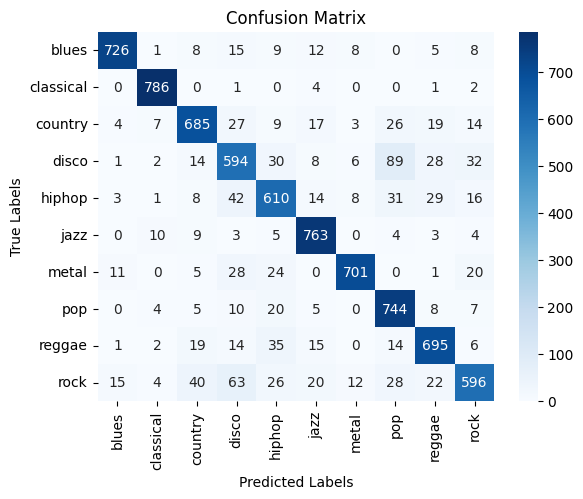

In [78]:
c_matrix = confusion_matrix(tot_label, tot_pred)

plt.figure()
sns.heatmap(c_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [61]:
torch.save(model.state_dict(), "model.pth")

10
